# Leaky Integrate and Fire

---
# Preparación

In [1]:
# @title Instalen e importen el aparato de respuesta

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W2D3_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Configuraciones de figura
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [4]:
# @title Funciones de gráfico

def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])
  plt.show()


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()

---
# Sección 1: El modelo de integración permeable y disparo (LIF)

## Ejercicio de programación 1: Programar en Python para similar la neurona LIF


Ahora vamos a escribir código en Python para calcular nuestra ecuación para la neurona LIF y simular las dinámicas de la misma. Vamos a utilizar el método de Euler, el cual vieron en el caso de sistemas lineales de ayer para integrar numéricamente esta ecuación:

\begin{equation}
\tau_m\frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L}\,
\end{equation}

Donde $V$ es el potencial de membrana, $g_L$ es la conductancia de fuga, $E_L$ es el potencial de reposo, $I$ es el valor de entrada de la corriente externa y  $\tau_m$ es la constante de tiempo de la membrana.


La celda de abajo inicia un diccionario que contiene parámetros del modelo de neurona LIF y el esquema de la simulación. Pueden utilizar `pars=default_pars(T=simulation_time, dt=time_step)` para obtener los parámetros. Noten que `simulation_time` y `time_step` tienen la unidad `ms`.Además, pueden añadir el valor a un nuevo parámetro con `pars['New_param'] = value`.

In [5]:
# @markdown Ejecuten este código para iniciar los parámetros de default

def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -65.   # initial potential [mV]
  pars['E_L'] = -65.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
print(pars)

{'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -65.0, 'E_L': -65.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.1, 'range_t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
       3.999e+02])}


Completen la función de abajo para simular a la neurona LIF cuando recibe estímulos de corriente externa. Pueden usar `v, sp = run_LIF(pars, Iinj)` para obtener el potencial de membrana (`v`) y el tren de espigas(`sp`) dado el diccionario `pars` y el valor de entrada de la corriente `Iinj`.

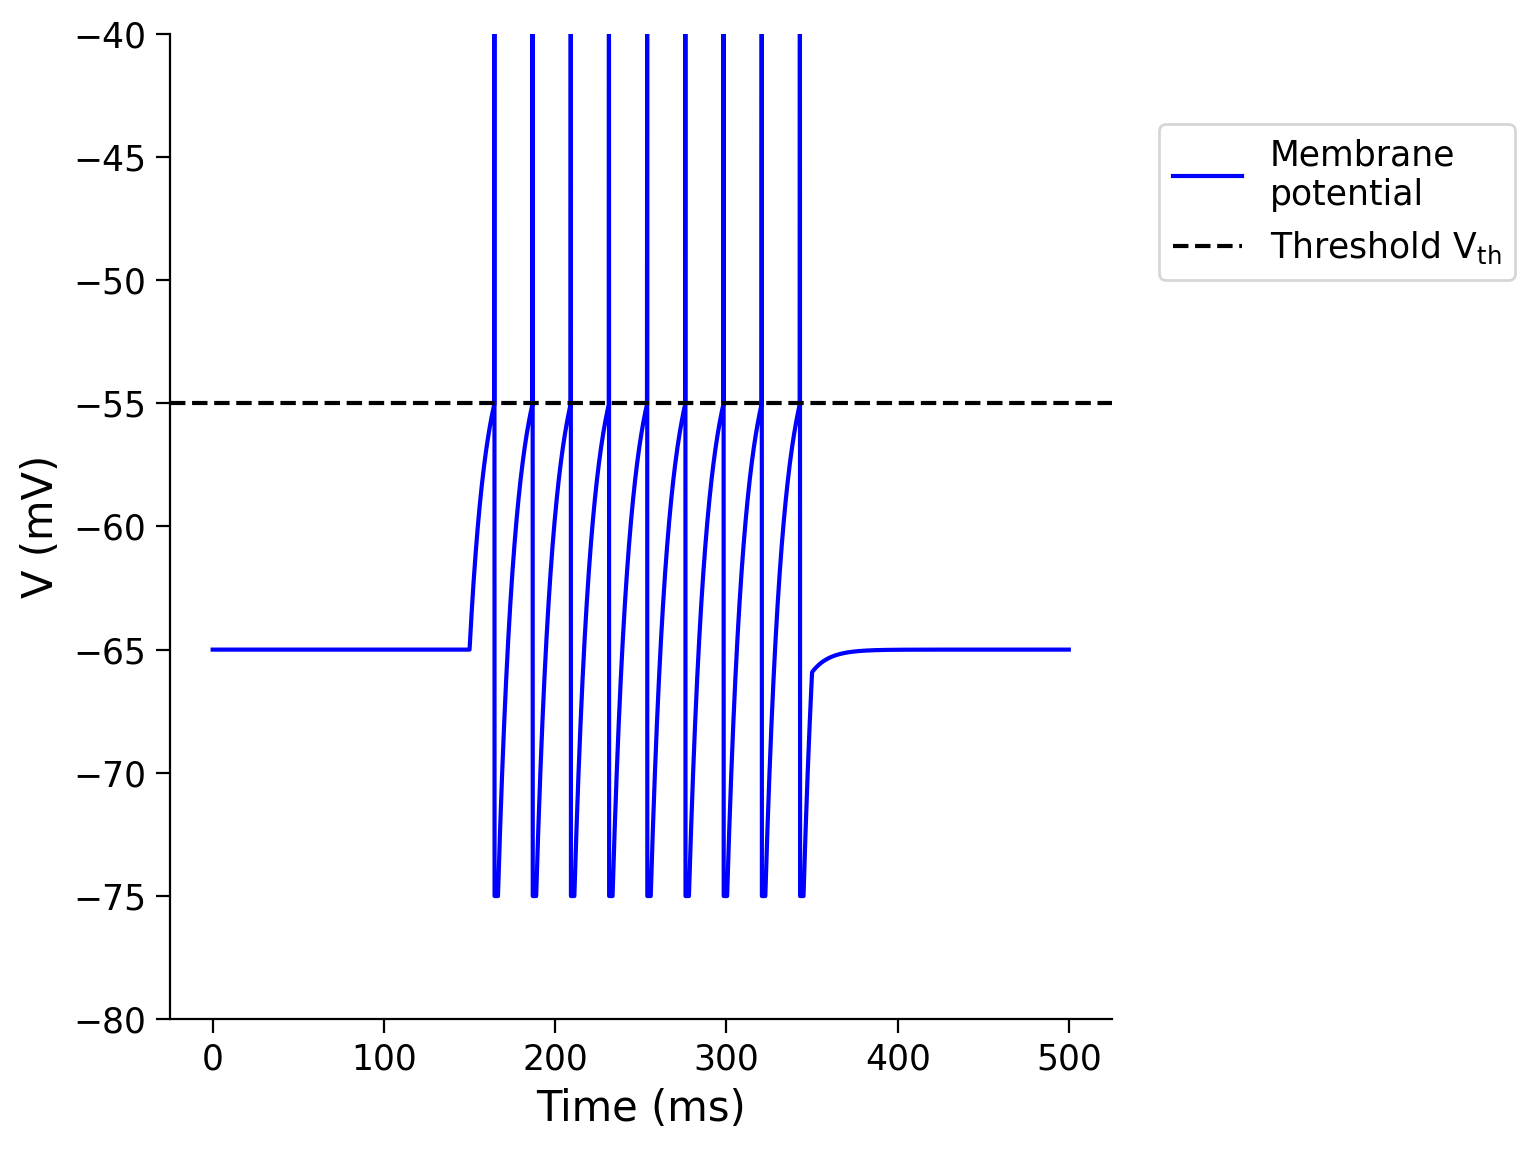

In [22]:
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # If current pulse, set beginning and end to 0
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0

  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration

  for it in range(Lt - 1):

    if tr > 0:  # check if in refractory period
      v[it] = V_reset  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period

    elif v[it] >= V_th:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      v[it] = V_reset  # reset voltage
      tr = tref / dt  # set refractory time

    ########################################################################

    # Calculate the increment of the membrane potential
    dv = dt*(-(v[it] - E_L) + Iinj[it] / g_L)/ tau_m

    # Update the membrane potential
    v[it + 1] = v[it] + dv

  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


# Get parameters
pars = default_pars(T=500)

# Simulate LIF model
pars['tref'] = 2.0 #Tiempo refractario
pars['tau_m'] = 10
v, sp = run_LIF(pars, Iinj=130, stop=True) #Probá con Iinj=100 y un poquito más

# Visualize
plot_volt_trace(pars, v, sp)

---
# Respuesta del modelo LIF a diferentes tipos de estímulos de corriente


En la siguiente sección vamos a aprender acerca de cómo inyectar corriente directa y ruido blanco para estudiar la respuesta de una neurona LIF


## Pregunta
## Hay muchas "entradas-salidas" que podemos mirar. En particular, queremos ver la _tasa de disparo_ en función de la _corriente de entrada_ (constante). Que forma va a tener esa función?

### Respuesta:

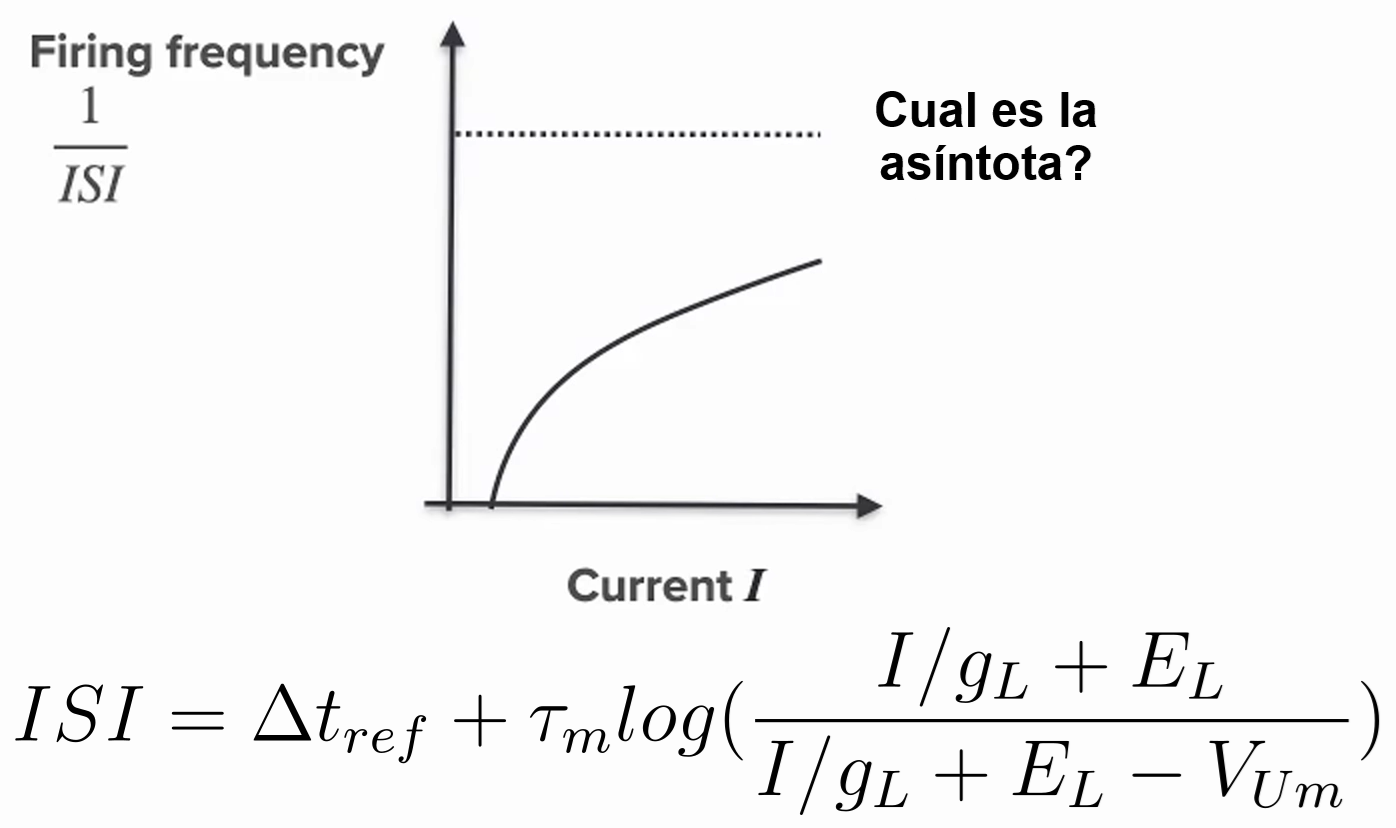

### Demo interactiva 2.1: Exploración de los parámetros de la amplitud de los valores de entrada de la corriente directa (DC)
Acá hay una demo interactiva que muestra cómo el comportamiento de una neurona LIF cambia por estímulos de DC (corriente constante) con diferentes amplitudes. Nosotros graficamos el potencial de membrana de una neurona LIF. Quizás te hayas dado cuenta de que la neurona genera una espiga. Pero esta es solo una espiga cosmética por motivos de ilustración. En una neurona LIF solo necesitamos llevar registro del tiempo cuando la neurona alcanza el umbral de forma que las neuronas postsinápticas puedan ser informadas de la espiga.


¿Cuánta DC se necesita para llegar al umbral (corriente de reobase)? ¿Cómo afecta la constante de tiempo de la membrana a la frecuencia de la neurona?


In [7]:
# @markdown Asegurate de ejectucar esta celda para habilitar el dispositivo!
my_layout.width = '450px'
@widgets.interact(
    I_dc=widgets.FloatSlider(50., min=0., max=300., step=10.,
                             layout=my_layout),
    tau_m=widgets.FloatSlider(10., min=2., max=20., step=2.,
                              layout=my_layout)
)

def diff_DC(I_dc=200., tau_m=10.):
  pars = default_pars(T=100.)
  pars['tau_m'] = tau_m
  v, sp = run_LIF(pars, Iinj=I_dc)
  plot_volt_trace(pars, v, sp)
  plt.show()

interactive(children=(FloatSlider(value=50.0, description='I_dc', layout=Layout(width='450px'), max=300.0, ste…

## Sección 2.2: Corriente de ruido blanco Gaussiano (GWN)


Dada la naturaleza ruidosa de la actividad neuronal ruidosa _in vivo_, las neuronas usualmente reciben valores de entrada complejos con variaciones de tiempo.


Para imitar esto, ahora vamos a investigar la respuesta neuronal cuando la neurona LIF recibe ruido blanco Gaussiano $\xi(t)$ con promedio 0 ($\mu = 0$) y una desviación estándar $\sigma$.


$C \frac{dV}{dt} = -g_L (V-E_L) + I + \xi(t)$

In [8]:
# @markdown ejecute para habilitar la función de ayuda `my_GWN`

def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn

# help(my_GWN)

In [23]:
# @markdown Asegurese de ejecutar esta celda para habilitar el dispositivo!

my_layout.width = '450px'
@widgets.interact(
    I_dc=widgets.FloatSlider(90., min=80., max=300., step=5.,
                               layout=my_layout),
    sig_gwn=widgets.FloatSlider(0, min=0., max=10., step=.5,
                                layout=my_layout)
)


def diff_GWN_to_LIF(I_dc, sig_gwn):
  pars = default_pars(T=100.)
  I_GWN = my_GWN(pars, mu=I_dc, sig=sig_gwn)
  v, sp = run_LIF(pars, Iinj=I_GWN)
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=90.0, description='I_dc', layout=Layout(width='450px'), max=300.0, min…

### Preguntas:
1. Como varía la regularidad de los ISI con el ruido? Que métrica puedo usar en vez de _*el*_ ISI/_*la*_ frecuencia para tener una idea de lo mismo?
2. Como es ahora la curva de respuesta $f(I)$?

### Respuesta

In [10]:
# @markdown Asegurese de ejecutar esta celda para habilitar el dispositivo!

my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(3.0, min=0., max=20., step=0.5,
                                layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(0., 400., 10.)
  spk_count = np.zeros(len(I_mean))
  spk_count_dc = np.zeros(len(I_mean))

  for idx in range(len(I_mean)):
      I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn, myseed=2020)
      v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
      v_dc, rec_sp_dc = run_LIF(pars, Iinj=I_mean[idx])
      spk_count[idx] = len(rec_spikes)
      spk_count_dc[idx] = len(rec_sp_dc)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean, spk_count, 'k',
           label=r'$\sigma_{\mathrm{GWN}}=%.2f$' % sig_gwn)
  plt.plot(I_mean, spk_count_dc, 'k--', alpha=0.5, lw=4, dashes=(2, 2),
           label='DC input')
  plt.ylabel('Spike count')
  plt.xlabel('Average injected current (pA)')
  plt.legend(loc='best')
  plt.show()

interactive(children=(FloatSlider(value=3.0, description='sig_gwn', layout=Layout(width='450px'), max=20.0, st…

Se dice que el ruido _*linealiza*_ la respuesta

---
# Notar que, para una misma frecuencia media, podemos tener mucha diferencia de ISIs!


La regularidad de los spikes se puede cuantificar en el **coeficiente de variación (CV) del ISI**:


\begin{equation}
\text{CV}_{\text{ISI}} = \frac{std(\text{ISI})}{media(\text{ISI})}
\end{equation}

### Preguntas

* Cual es el CV de una neurona de Poisson como las que vimos en las primeras clases? (recuerden que tiempo entre eventos en un proceso de Poisson tiene distribución exponencial)
* Cual es el CV de una neurona con entrada sin ruido?

## Ejercicio de programación 3: Computar valores de $CV_{ISI}$

Como se mostró arriba, la curva F-I se vuelve más plana a medida que aumenta la amplitud de la fluctuación ($\sigma$).Además,la fluctuación también puede cambiar la irregularidad de las espigas. Investiguemos el efecto de $\mu=250$ con $\sigma=0.5$ vs $\sigma=3$.


Llenen el código debajo para computar ISI, luego grafique el histograma de la ISI y computen el valor de $CV_{ISI}$. Noten que, pueden usar `np.diff` para calcular ISI.

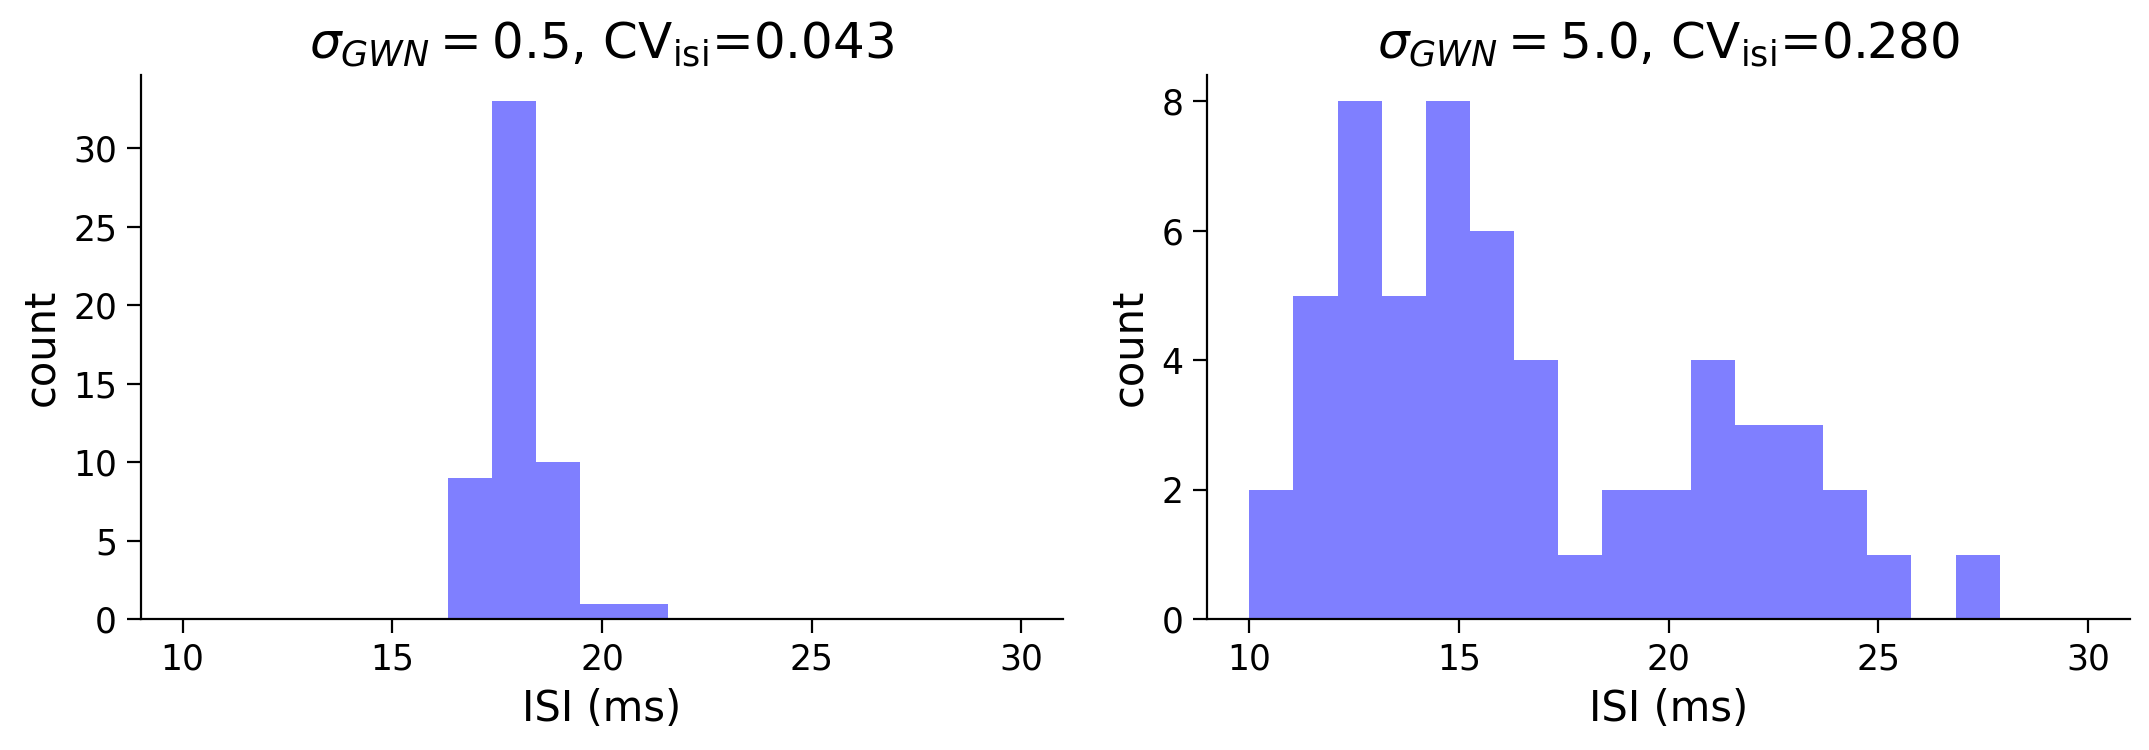

In [11]:
def isi_cv_LIF(spike_times):
  """
  Calculates the interspike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train

  Args:
    spike_times : (n, ) vector with the spike times (ndarray)

  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)

  """
  ########################################################################
  if len(spike_times) >= 2:
    # Compute isi
    isi = np.diff(spike_times)
    # Compute cv
    cv = isi.std()/isi.mean()
  else:
    isi = np.nan
    cv = np.nan

  return isi, cv


# Set parameters
pars = default_pars(T=1000.)
pars['V_init'] = -75
pars['E_L'] = -75
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 5.0

# Run LIF model for sigma = 0.5
I_GWN1 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn1, myseed=2020)
_, sp1 = run_LIF(pars, Iinj=I_GWN1)

# Run LIF model for sigma = 3
I_GWN2 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn2, myseed=2020)
_, sp2 = run_LIF(pars, Iinj=I_GWN2)

# Compute ISIs/CV
isi1, cv1 = isi_cv_LIF(sp1)
isi2, cv2 = isi_cv_LIF(sp2)

# Visualize
my_hists(isi1, isi2, cv1, cv2, sig_gwn1, sig_gwn2)

#Ambos gráficos tienen la misma entrada media I=250 y aprox misma ISI media ~17. Como difieren en su regularidad?

## Demo interactiva 3B: Explorador de irregularidades en las espigas para diferentes `sig_gwn`

En la ilustración de arriba vemos que el CV de la distribución del intervalo entre espigas (ISI) depende de $\sigma$ de GWN. Que tal el promedio de GWN, debería eso afectar el CV$_{\rm ISI}$? En caso positivo, como? Depende la eficacia de $\sigma$ en incrementar el CV$_{\rm ISI}$ dependiente de $\mu$?


En la siguiente demo interactiva vas a examinar cómo diferentes niveles de fluctuación $\sigma$ afectan los CVs para diferentes promedio de corriente inyectados($\mu$).


1. ¿Afecta la desviación estándar de la corriente inyectada a la curva F-I en alguna forma cualitativa?
2. ¿Por qué incrementar el promedio de GWN reduce el CV$_{\rm ISI}$?
3.  Si graficas el contador de espigas (o frecuencia) vs. CV${\rm ISI}$, ¿debería haber alguna relación entre las dos? Comprobalo por vos mismo

In [12]:
# @markdown Asegurese de ejecutar esta celda para habilitar el dispositivo!

my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(0.0, min=0., max=10.,
                                step=0.5, layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(100., 600., 20)
  spk_count = np.zeros(len(I_mean))
  cv_isi = np.empty(len(I_mean))

  for idx in range(len(I_mean)):
    I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn)
    v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
    spk_count[idx] = len(rec_spikes)
    if len(rec_spikes) > 3:
      isi = np.diff(rec_spikes)
      cv_isi[idx] = np.std(isi) / np.mean(isi)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean[spk_count > 5], cv_isi[spk_count > 5], 'bo', alpha=0.5)
  plt.xlabel('Average injected current (pA)')
  plt.ylabel(r'Spike irregularity ($\mathrm{CV}_\mathrm{ISI}$)')
  plt.ylim(-0.1, 1.5)
  plt.grid(True)
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='sig_gwn', layout=Layout(width='450px'), max=10.0, st…

En general hablamos de estar en régimenes "dirigidos por la media" o "dirigidos por el ruido" (mean-driven y noise-driven regimes)

---
# Pregunta: Como varía el CV en una neurona Poissoniana? Recordar que la tasa de disparo $\lambda \propto I(t)$



